<a href="https://colab.research.google.com/github/mgswiss15/deepul/blob/magda/homeworks/hw1/hw1_Q3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !if [ -d deepul ]; then rm -Rf deepul; fi
    !git clone -b magda https://github.com/mgswiss15/deepul.git 
    !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
    !pip install ./deepul
else:
    %load_ext autoreload
    %autoreload 2
    import sys
    import pathlib
    cwd = pathlib.Path().absolute()
    sys.path.append(str(cwd.parents[0]))
    sys.path.append(str(cwd.parents[1]))
    print(sys.path)

['/home/magda/Github/deepul/homeworks/hw1', '/home/magda/anaconda3/envs/pytorch/lib/python38.zip', '/home/magda/anaconda3/envs/pytorch/lib/python3.8', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/lib-dynload', '', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages', '/home/magda/anaconda3/envs/pytorch/lib/python3.8/site-packages/IPython/extensions', '/home/magda/.ipython', '/home/magda/Github/deepul/homeworks', '/home/magda/Github/deepul']


In [2]:
if IN_COLAB:
    from deepul.hw1_helper import *
else:
    from hw1_helper import *

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

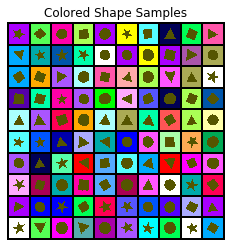

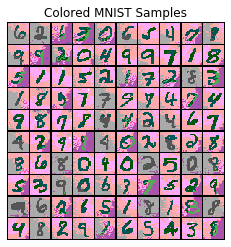

In [3]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
import time
from deepul.exp_utils import *

class MaskedConv2d(nn.Conv2d):
    """Masked convolution layer as in PixelCNN
    
    detials in Oord et. al (2016): Pixel Recurent Neural Networks
    this version:
        - assumes RGB = 3 color channels
        - has no A, B types
        - treats all color channels as independent
    """
    def __init__(self, masktype, in_channels, out_channels, kernel_size, stride=1, padding=0):
        # for the moment masktypes don't do anything
        assert masktype in ('A', 'B'), 'masktype has to be A or B'
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.mask = nn.Parameter(torch.zeros(out_channels, in_channels, *self.kernel_size), requires_grad=False)
        k_size = self.kernel_size[0]
        kernel_mid = k_size // 2
        out_R = out_channels // 3
        out_G = 2 * out_R
        in_R = in_channels // 3
        in_G = 2 * in_R
        if kernel_mid==0:
            self.mask[:] = 1.
        else:
            self.mask[:out_R, :in_R, :kernel_mid, :] = 1.
            self.mask[:out_R, :in_R, kernel_mid, :kernel_mid] = 1.
            self.mask[out_R:out_G, in_R:in_G, :kernel_mid, :] = 1.
            self.mask[out_R:out_G, in_R:in_G, kernel_mid, :kernel_mid] = 1.
            self.mask[out_G:, in_G:, :kernel_mid, :] = 1.
            self.mask[out_G:, in_G:, kernel_mid, :kernel_mid] = 1.
        
    def forward(self, x):
        return self._conv_forward(x, self.weight * self.mask)   
    
class LayerNorm(nn.Module):
    """Layer norm for masked conv layers
    
    normalization across channels
    this version:
        - assumes RGB = 3 color channels
        - treats all color channels as independent
    """
    def __init__(self):
        super(LayerNorm, self).__init__()
        
    def forward(self, x):
        # careful about the autoregressive property
        # so far, nothing
        # colors are treated independently - ok
        # pixels should not be averaged or it breaks the autoregressions
        rgb_chunks = torch.chunk(x, 3, dim=1)
        normed = []
        for one_chunk in rgb_chunks:
            means = torch.mean(one_chunk, dim=1, keepdim=True)
            std = torch.std(one_chunk, dim=1, keepdim=True)
            one_chunk = (one_chunk - means) / std
            normed.append(one_chunk)
        return torch.cat(normed, dim=1)

    
class ResBlock(nn.Module):
    def __init__(self, filters):
        super(ResBlock, self).__init__()
        layers = []
        layers.append(nn.ReLU())              
        layers.append(MaskedConv2d('B', filters, filters // 2, 1))
        layers.append(nn.ReLU())              
        layers.append(MaskedConv2d('B', filters // 2, filters // 2, 7, padding=3))
        layers.append(nn.ReLU())              
        layers.append(MaskedConv2d('B', filters //2 , filters, 1))
        self.resblock = nn.Sequential(*layers)
        
    def forward(self, x):
        res = self.resblock(x)
        return res + x   

        
class PixelCNN(nn.Module):
    def __init__(self, image_shape, color_cats, filters=120):
        super(PixelCNN, self).__init__()
        self.image_shape = image_shape  # H, W, C
        self.color_cats = color_cats
        layers = []
        layers.append(MaskedConv2d('A', self.image_shape[2], filters, 7, padding=3))
        for i in range(8):
            layers.append(LayerNorm())
            layers.append(ResBlock(filters))
        layers.append(LayerNorm())
        layers.append(nn.ReLU())
        layers.append(MaskedConv2d('B', filters, filters, 1))
        layers.append(LayerNorm())
        layers.append(nn.ReLU())
        layers.append(MaskedConv2d('B', filters, self.image_shape[2]*color_cats, 1))
        self.sequential = nn.Sequential(*layers)
        self.loss_func = nn.CrossEntropyLoss(reduction='none')
        
    def forward(self, x):
        # rescale to [-1, 1]
        x = x.float() / ((self.color_cats-1)/2) - 1
        logits = self.sequential(x)
        h, w, c = self.image_shape
        logits = logits.view(-1, self.color_cats, c, h, w)
        return logits
        
    def loss_function(self, preds, target):
        loss = self.loss_func(preds, target.long())
        loss = torch.sum(loss, (3, 2, 1))
        loss = loss.mean(dim=0)
        return loss
    
    def sampling(self, size):
        start_time = time.time()
        print(f'Begin sampling')
        self.eval()
        with torch.no_grad():
            sample = torch.ones(size, *self.image_shape)
            sample = sample.permute(0, 3, 1, 2)
            if next(self.parameters()).is_cuda:
                sample = sample.cuda()
            for i in range(self.image_shape[0]):
                for j in range(self.image_shape[1]):
                    logits = self(sample)
                    lsm = F.softmax(logits, dim=1)
                    sr = torch.multinomial(lsm[:, :, 0, i, j], num_samples=1)
                    sg = torch.multinomial(lsm[:, :, 1, i, j], num_samples=1)
                    sb = torch.multinomial(lsm[:, :, 2, i, j], num_samples=1)
                    sample[:, :, i, j] = torch.cat((sr, sg, sb), dim=1)
                print(f'Sampled row {i}')
            images = sample.permute(0, 2, 3, 1)
            print(images.shape)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f'End sampling, elapsed {elapsed}')
        return images

In [5]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """

    """ YOUR CODE HERE """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
#     train_data = train_data[:12, :, :5, :5]
#     test_data = test_data[:12, :, :5, :5]
#     image_shape = (5, 5, 3)

    DEVICE = torch.device('cpu')
    train_loader, test_loader = get_loaders(train_data, test_data, bs=12)
    model = PixelCNN((image_shape), color_cats=4, filters=120).to(DEVICE)
    optim_algo = torch.optim.Adam
    nll_train, nll_test = training(
        train_loader, test_loader,
        model, optim_algo, learn_rate=0.001, device=DEVICE, epochs=15)
    npixels = np.prod(np.array(image_shape))
    nll_train = np.array(nll_train) / npixels
    nll_test = np.array(nll_test) / npixels
    sample = model.sampling(100).cpu().numpy()
    return nll_train, nll_test, sample

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



Epoch 0 loss train: 104.85614013671875, test: 101.61006927490234
Epoch 1 loss train: 94.15059661865234, test: 99.48894500732422
Begin sampling
Sampled row 0
Sampled row 1
Sampled row 2
Sampled row 3
Sampled row 4
torch.Size([100, 5, 5, 3])
End sampling, elapsed 0.9951357841491699
Final Test Loss: 1.3265


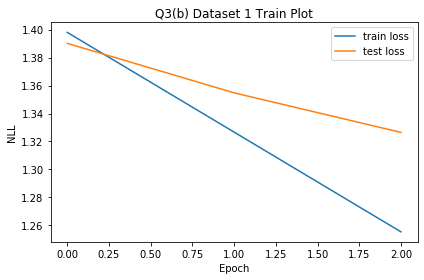

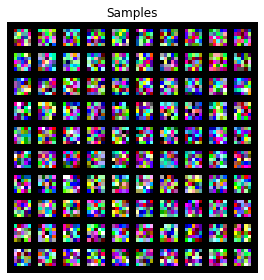

In [6]:
q3bc_save_results(1, 'b', q3_b)

Epoch 0 loss train: 108.97061920166016, test: 86.09085083007812
Epoch 1 loss train: 86.55864715576172, test: 68.79255676269531
Begin sampling
Sampled row 0
Sampled row 1
Sampled row 2
Sampled row 3
Sampled row 4
torch.Size([100, 5, 5, 3])
End sampling, elapsed 1.1101133823394775
Final Test Loss: 0.9172


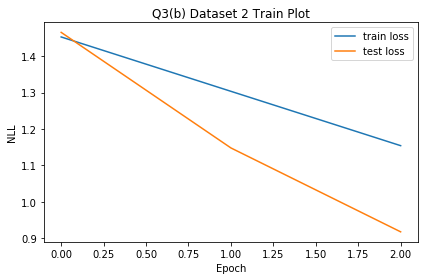

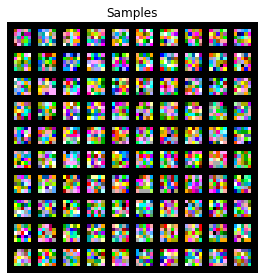

In [7]:
q3bc_save_results(2, 'b', q3_b)